# Lab 4c. Deep Learning - iNaturalist
### Desik Somasundaram

## Import packages

In [ ]:
import keras
import os, shutil
import pandas
from random import sample
keras.__version__

## Explore data

In [265]:
# Examine original iNat data
os. getcwd() 
dir_train_mini = "./data/train_mini"
dirs_spp = os.listdir(dir_train_mini)
n_spp = len(dirs_spp) # 10,000 species directories
n_spp 

10000

In [266]:
# Sample 10 species randomly
i10 = sample(range(1,n_spp),10)
i10

[2871, 7512, 2767, 891, 3095, 6761, 3349, 7908, 5241, 589]

In [283]:
# show/select the first 2 species directory names from random 10
i2 = i10[0:2]

## Copy over, Read in and Prep data

In [268]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini'

# The directory where we will
# store our smaller dataset
base_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini_subset'
# this line clear the base dir, comment out if you don't want to start over
shutil.rmtree(base_dir)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [269]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [284]:
# Select 2 species for first two parts of lab
speciesfolders = []
for i in i2:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['01339_Animalia_Arthropoda_Insecta_Lepidoptera_Hesperiidae_Atalopedes_campestris',
 '09176_Plantae_Tracheophyta_Magnoliopsida_Ranunculales_Papaveraceae_Eschscholzia_minutiflora']

In [271]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the two species selected in i2
i = 0
while i < len(i2):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [274]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i2):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [277]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [279]:
# sanity check on sizes of data splits
print('total test species 2 images:', len(os.listdir(test_species_folders[1])))

total test species 2 images: 10


In [280]:
# sanity check on sizes of data splits
print('total validation species 2 images:', len(os.listdir(validation_species_folders[1])))

total validation species 2 images: 10


In [281]:
# sanity check on sizes of data splits
print('total test species 1 images:', len(os.listdir(test_species_folders[0])))

total test species 1 images: 10


## 2 Species (binary classification) - neural net

In [180]:
# image preprocessing for model with binary classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [181]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4,)


### Neural net model

In [182]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [183]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# custom optimizer
#from tensorflow.keras import optimizers

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#              loss='binary_crossentropy',
#             metrics=['accuracy'])

# custom optimizer and custom loss/metrics
#from tensorflow.keras import losses
#from tensorflow.keras import metrics

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#             loss=losses.binary_crossentropy,
#             metrics=[metrics.binary_accuracy])

In [186]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 150, 150, 16)      64        
_________________________________________________________________
dense_31 (Dense)             (None, 150, 150, 16)      272       
_________________________________________________________________
dense_32 (Dense)             (None, 150, 150, 1)       17        
_________________________________________________________________
flatten_4 (Flatten)          (None, 22500)             0         
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [187]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 152ms/step - loss: 0.6919 - binary_accuracy: 0.5552 - val_loss: 0.6991 - val_binary_accuracy: 0.4972
Epoch 2/40
5/5 [==============================] - 0s 103ms/step - loss: 0.6850 - binary_accuracy: 0.6484 - val_loss: 0.6994 - val_binary_accuracy: 0.5000
Epoch 3/40
5/5 [==============================] - 0s 69ms/step - loss: 0.7064 - binary_accuracy: 0.4000 - val_loss: 0.6981 - val_binary_accuracy: 0.5000
Epoch 4/40
5/5 [==============================] - 0s 60ms/step - loss: 0.7011 - binary_accuracy: 0.4500 - val_loss: 0.6974 - val_binary_accuracy: 0.5000
Epoch 5/40
5/5 [==============================] - 1s 121ms/step - loss: 0.7049 - binary_accuracy: 0.3501 - val_loss: 0.6965 - val_binary_accuracy: 0.5053
Epoch 6/40
5/5 [==============================] - 0s 64ms/step - loss: 0.6973 - binary_accuracy: 0.4333 - val_loss: 0.6963 - val_binary_accuracy: 0.4968
Epoch 7/40
5/5 [==============================] - 1s 60ms/step - loss: 0.6948 -

In [188]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [189]:
model.save('2Species-binaryclassification-neuralnet.h5')

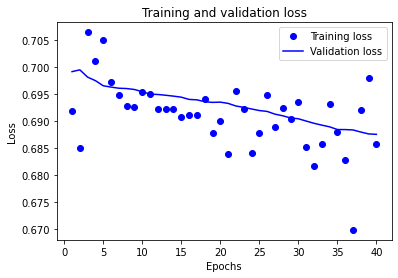

In [190]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2 Species (binary classification) - convolutional neural net

In [192]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [195]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)     

In [196]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 162ms/step - loss: 0.7338 - acc: 0.4500 - val_loss: 0.6901 - val_acc: 0.5500
Epoch 2/40
5/5 [==============================] - 1s 102ms/step - loss: 0.6885 - acc: 0.5000 - val_loss: 0.7081 - val_acc: 0.5000
Epoch 3/40
5/5 [==============================] - 0s 94ms/step - loss: 0.6712 - acc: 0.6500 - val_loss: 0.7353 - val_acc: 0.5000
Epoch 4/40
5/5 [==============================] - 1s 116ms/step - loss: 0.7270 - acc: 0.6000 - val_loss: 0.7019 - val_acc: 0.5000
Epoch 5/40
5/5 [==============================] - 1s 106ms/step - loss: 0.7084 - acc: 0.4500 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 6/40
5/5 [==============================] - 0s 98ms/step - loss: 0.7008 - acc: 0.4000 - val_loss: 0.6896 - val_acc: 0.5000
Epoch 7/40
5/5 [==============================] - 0s 94ms/step - loss: 0.6942 - acc: 0.5000 - val_loss: 0.6835 - val_acc: 0.5500
Epoch 8/40
5/5 [==============================] - 0s 77ms/step - loss: 0.6639 - acc: 0.7500 -

In [197]:
model.save('2Species-binaryclassification-convnet.h5')

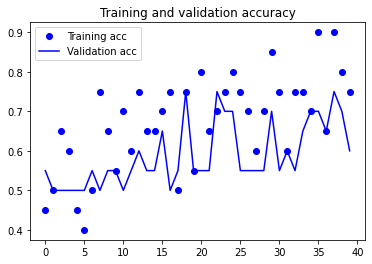

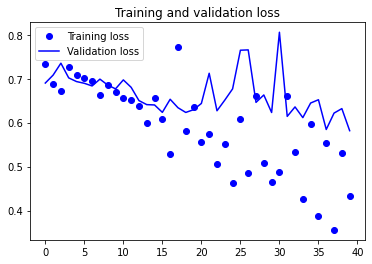

In [199]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Write up comparing results

# 10 Species (multi-class classification) - neural net

In [286]:
# Select 10 species for second two parts of lab
speciesfolders = []
for i in i10:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['01339_Animalia_Arthropoda_Insecta_Lepidoptera_Hesperiidae_Atalopedes_campestris',
 '09176_Plantae_Tracheophyta_Magnoliopsida_Ranunculales_Papaveraceae_Eschscholzia_minutiflora',
 '02116_Animalia_Arthropoda_Insecta_Lepidoptera_Pyralidae_Arta_olivalis',
 '09816_Plantae_Tracheophyta_Pinopsida_Pinales_Pinaceae_Pinus_banksiana',
 '02029_Animalia_Arthropoda_Insecta_Lepidoptera_Papilionidae_Papilio_polyxenes',
 '06167_Plantae_Tracheophyta_Liliopsida_Liliales_Liliaceae_Gagea_minima',
 '09016_Plantae_Tracheophyta_Magnoliopsida_Myrtales_Myrtaceae_Metrosideros_excelsa',
 '07074_Plantae_Tracheophyta_Magnoliopsida_Asterales_Asteraceae_Xanthisma_spinulosum',
 '08182_Plantae_Tracheophyta_Magnoliopsida_Fagales_Fagaceae_Quercus_gambelii',
 '02805_Animalia_Chordata_Actinopterygii_Perciformes_Centrarchidae_Lepomis_megalotis']

In [287]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the ten species selected in i10
i = 0
while i < len(i10):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [288]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i10):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [289]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [290]:
# sanity check on sizes of data splits
print('total test species 3 images:', len(os.listdir(test_species_folders[2])))

total test species 3 images: 10


In [291]:
# sanity check on sizes of data splits
print('total validation species 9 images:', len(os.listdir(validation_species_folders[8])))

total validation species 9 images: 10


In [324]:
# image preprocessing for model with multi classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='categorical')

Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [325]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (5, 150, 150, 3)
labels batch shape: (5, 10)


### Neural net model

In [391]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(150,150,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [392]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [393]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 150, 150, 64)      256       
_________________________________________________________________
flatten_27 (Flatten)         (None, 1440000)           0         
_________________________________________________________________
dense_101 (Dense)            (None, 64)                92160064  
_________________________________________________________________
dense_102 (Dense)            (None, 10)                650       
Total params: 92,160,970
Trainable params: 92,160,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 351ms/step - loss: 129.5844 - accuracy: 0.1200 - val_loss: 78.8057 - val_accuracy: 0.1200
Epoch 2/40
5/5 [==============================] - 2s 316ms/step - loss: 70.5597 - accuracy: 0.1200 - val_loss: 34.1957 - val_accuracy: 0.1200
Epoch 3/40
5/5 [==============================] - 2s 318ms/step - loss: 28.4235 - accuracy: 0.2000 - val_loss: 16.8097 - val_accuracy: 0.1600
Epoch 4/40
5/5 [==============================] - 2s 315ms/step - loss: 17.7826 - accuracy: 0.1200 - val_loss: 11.3374 - val_accuracy: 0.0400
Epoch 5/40
5/5 [==============================] - 2s 317ms/step - loss: 18.7166 - accuracy: 0.0400 - val_loss: 14.6923 - val_accuracy: 0.2000
Epoch 6/40
5/5 [==============================] - 2s 323ms/step - loss: 17.0231 - accuracy: 0.1600 - val_loss: 8.4245 - val_accuracy: 0.1600
Epoch 7/40
5/5 [==============================] - 2s 316ms/step - loss: 3.8208 - accuracy: 0.4000 - val_loss: 7.4106 - val_accuracy: 0.1600
Epoch 8/

In [ ]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

In [ ]:
model.save('10Species-multiclassification-neuralnet.h5')

In [ ]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 10 Species (multi classification) - convolutional neural net

In [356]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [357]:
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)     

In [358]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 109ms/step - loss: 2.7776 - accuracy: 0.0800 - val_loss: 2.3101 - val_accuracy: 0.1600
Epoch 2/40
5/5 [==============================] - 0s 84ms/step - loss: 2.3321 - accuracy: 0.0400 - val_loss: 2.3036 - val_accuracy: 0.0800
Epoch 3/40
5/5 [==============================] - 1s 106ms/step - loss: 2.3015 - accuracy: 0.0800 - val_loss: 2.4019 - val_accuracy: 0.0000e+00
Epoch 4/40
5/5 [==============================] - 1s 111ms/step - loss: 2.3337 - accuracy: 0.1200 - val_loss: 2.3070 - val_accuracy: 0.0800
Epoch 5/40
5/5 [==============================] - 1s 107ms/step - loss: 2.3360 - accuracy: 0.1600 - val_loss: 2.2970 - val_accuracy: 0.1600
Epoch 6/40
5/5 [==============================] - 1s 105ms/step - loss: 2.3025 - accuracy: 0.1600 - val_loss: 2.2998 - val_accuracy: 0.1600
Epoch 7/40
5/5 [==============================] - 0s 103ms/step - loss: 2.3092 - accuracy: 0.1200 - val_loss: 2.3039 - val_accuracy: 0.0800
Epoch 8/40
5/5 [=

In [359]:
model.save('10Species-multiclassification-convnet.h5')

In [361]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

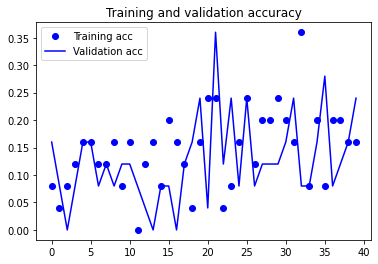

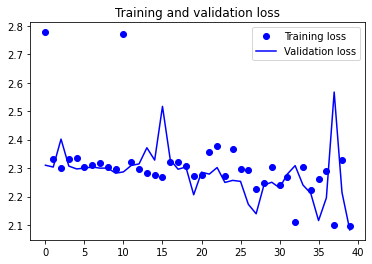

In [363]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Write up comparing results